## Importing Packages

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import json
from utils.random import random_lba_2A
from utils.utils import get_dfs, calculate_waic, bci, plot_mean_posterior
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = "../"
plots_root = "Results/individual/Plots/"
datasets_root = root + "Datasets/"
behavioural_data_root = datasets_root +  "behavioral_data/selected_data/" 
stan_files_root = root +  "models/stan/" 
saved_models_root = "Results/individual/stan_results/"

model_config = {}
plots_path = ""
dataset_path = ""
stan_file_path = ""
stan_output_dir = ""

#### read models configuration json file

In [4]:
with open("../models/lba_based_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())
    models_name = list(
        filter(lambda model_name: "individual" in model_name,
               models_name))

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config["plots_folder_name"] + "/"
    dataset_path = datasets_root + "AI Models Results/" + model_config["dataset_name"]
    stan_file_path = stan_files_root + model_config["stan_file"]
    stan_output_dir = saved_models_root + model_config["model_name"] + "/"
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('ANN-LBA_full_individual',), value='ANN-LBA_…

In [6]:
model_config

{'model_name': 'ANN-LBA_full_s_FT',
 'stan_file': 'ANN-LBA/individual/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-LBA_full_s_FT',
 'transf_params': ['transf_k_word',
  'transf_k_nonword',
  'transf_sp_trial_var_word',
  'transf_sp_trial_var_nonword',
  'transf_g',
  'transf_m',
  'transf_alpha',
  'transf_b',
  'transf_theta_1',
  'transf_theta_2',
  'transf_drift_variability']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + "LDT_data.csv",
                             header=None,
                             names=["accuracy", "rt", "string", "response",
                                    "participant", "minRT", "participant_id"])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on="string", how="left").dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.378,bodule,0,0.378,1,0.0,0.000000,NW,0.000013,0.999987
1,1,0.415,remember,1,0.378,1,1.0,5.733796,HF,0.999947,0.000053
2,1,0.425,mellow,1,0.378,1,1.0,3.479355,HF,0.999825,0.000175
3,1,0.430,gluff,0,0.378,1,0.0,0.000000,NW,0.000001,0.999999
4,1,0.435,imversion,0,0.378,1,0.0,0.000000,NW,0.000750,0.999250


In [10]:
# Chossing a participant
behavioural_df = behavioural_df.loc[behavioural_df["participant_id"] == 1]
behavioural_df

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.378,bodule,0,0.378,1,0.0,0.000000,NW,0.000013,0.999987
1,1,0.415,remember,1,0.378,1,1.0,5.733796,HF,0.999947,0.000053
2,1,0.425,mellow,1,0.378,1,1.0,3.479355,HF,0.999825,0.000175
3,1,0.430,gluff,0,0.378,1,0.0,0.000000,NW,0.000001,0.999999
4,1,0.435,imversion,0,0.378,1,0.0,0.000000,NW,0.000750,0.999250
...,...,...,...,...,...,...,...,...,...,...,...
365,1,2.291,suggested,1,0.378,1,1.0,4.012820,HF,0.999926,0.000074
366,1,2.340,underwater,1,0.378,1,1.0,3.802379,HF,0.999985,0.000014
367,1,2.366,parenthetically,1,0.378,1,1.0,1.768955,LF,0.999913,0.000087
368,1,2.398,underpay,1,0.378,1,1.0,1.893894,LF,0.999146,0.000854


Predicted probabilities of words and non-words in different conditions in all trials
across participants

## Stan Model and Estimation

Compiling stan model

In [11]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [12]:
N = len(behavioural_df)                                                    # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

k_priors = [1, 1]                  # All models with LBA
A_priors = [1, 1]                  # All models wtih LBA
ndt_priors = [0, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5]                # For models wtih non-decision time modulation
drift_priors = [1, 2]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1]              # For models with drift mapping functions
b_priors = [0, 1]                  # For models with drift mapping functions with asymptote modulation and linear models

# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)
sp_trial_var_priors = [1, 1]
drift_variability_priors = [1, 1]

# define input for the model
data_dict = {'N': N,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             'sp_trial_var_priors': sp_trial_var_priors,
             'drift_variability_priors': drift_variability_priors
             }

# set sampling parameters
n_iter = 2000
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [13]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)
Chain [2] sample
Chain [2] num_samples = 1000 (Default)
Chain [2] num_warmup = 1000 (Default)
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Chain [1] method = sample (Default)
Chain [2] metric = diag_e (Default)
Chain [2] metric_file =  (Default)
Chain [2] stepsize = 1 (Default)
Chain [2] stepsize_jitter = 0 (Default)
Chain [2] num_chains = 1 (Default)
Chain [2] id = 2
Chain [2] data
Chain [2] file = C:\Users\Arash\AppData\Local\Temp\tmphrm29xc1\lagdcigt.json
Chain [2] init = 2 (Default)
Chain 

12:42:37 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 35.894 seconds (Warm-up)
Chain [1] 41.947 seconds (Sampling)
Chain [1] 77.841 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 


12:42:38 - cmdstanpy - INFO - Chain [2] done processing
12:42:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: sigmoid_am_ndm_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-LBA/individual/sigmoid_am_ndm.stan', line 156, column 4 to column 37)
Consider re-running with show_console=True if the above output is unclear!


Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [2] 
Chain [2] Elapsed Time: 35.01 seconds (Warm-up)
Chain [2] 44.142 seconds (Sampling)
Chain [2] 79.152 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain 

## Loading Model

(In case model have been fitted before)

In [14]:
# fit = cmdstanpy.from_csv(stan_output_dir)

## Model diagnostics

In [15]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: E:\Workspace\Thesis\ANN-EAM\Estimations\Results\individual\stan_results\ANN-LBA_full_s_FT\ANN-LBA_full_s_FT-20230423124119_1.csv, E:\Workspace\Thesis\ANN-EAM\Estimations\Results\individual\stan_results\ANN-LBA_full_s_FT\ANN-LBA_full_s_FT-20230423124119_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [16]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-255.221000,0.104837,2.552270,-260.172000,-254.81300,-251.769000,592.689,6.88461,1.003880
k_word,-0.352834,0.013123,0.329860,-0.890006,-0.35678,0.198619,631.815,7.33909,1.002870
k_nonword,-0.148507,0.013464,0.348212,-0.738315,-0.15313,0.411494,668.866,7.76947,1.001810
sp_trial_var_word,1.654230,0.019195,0.530505,0.780935,1.65536,2.529510,763.849,8.87278,1.000470
sp_trial_var_nonword,2.465130,0.018390,0.505029,1.656830,2.44045,3.332390,754.195,8.76064,0.999966
...,...,...,...,...,...,...,...,...,...
log_lik[366],-5.606980,0.012944,0.619432,-6.678720,-5.57361,-4.660260,2290.230,26.60310,0.999425
log_lik[367],-4.503220,0.007042,0.334899,-5.083220,-4.48330,-3.998680,2261.890,26.27390,0.999392
log_lik[368],-2.943390,0.004149,0.188741,-3.290510,-2.93296,-2.652970,2069.250,24.03620,1.000920
log_lik[369],-2.996830,0.004221,0.191711,-3.349240,-2.98520,-2.702110,2062.660,23.95960,1.000930


In [17]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
0


In [18]:
df.loc[df["R_hat"]>1.01].to_csv("Results/individual/logs/" + model_config["model_name"] + "_rhat_log.csv")

In [19]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat


In [20]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check parameters

Parameters posterior plots

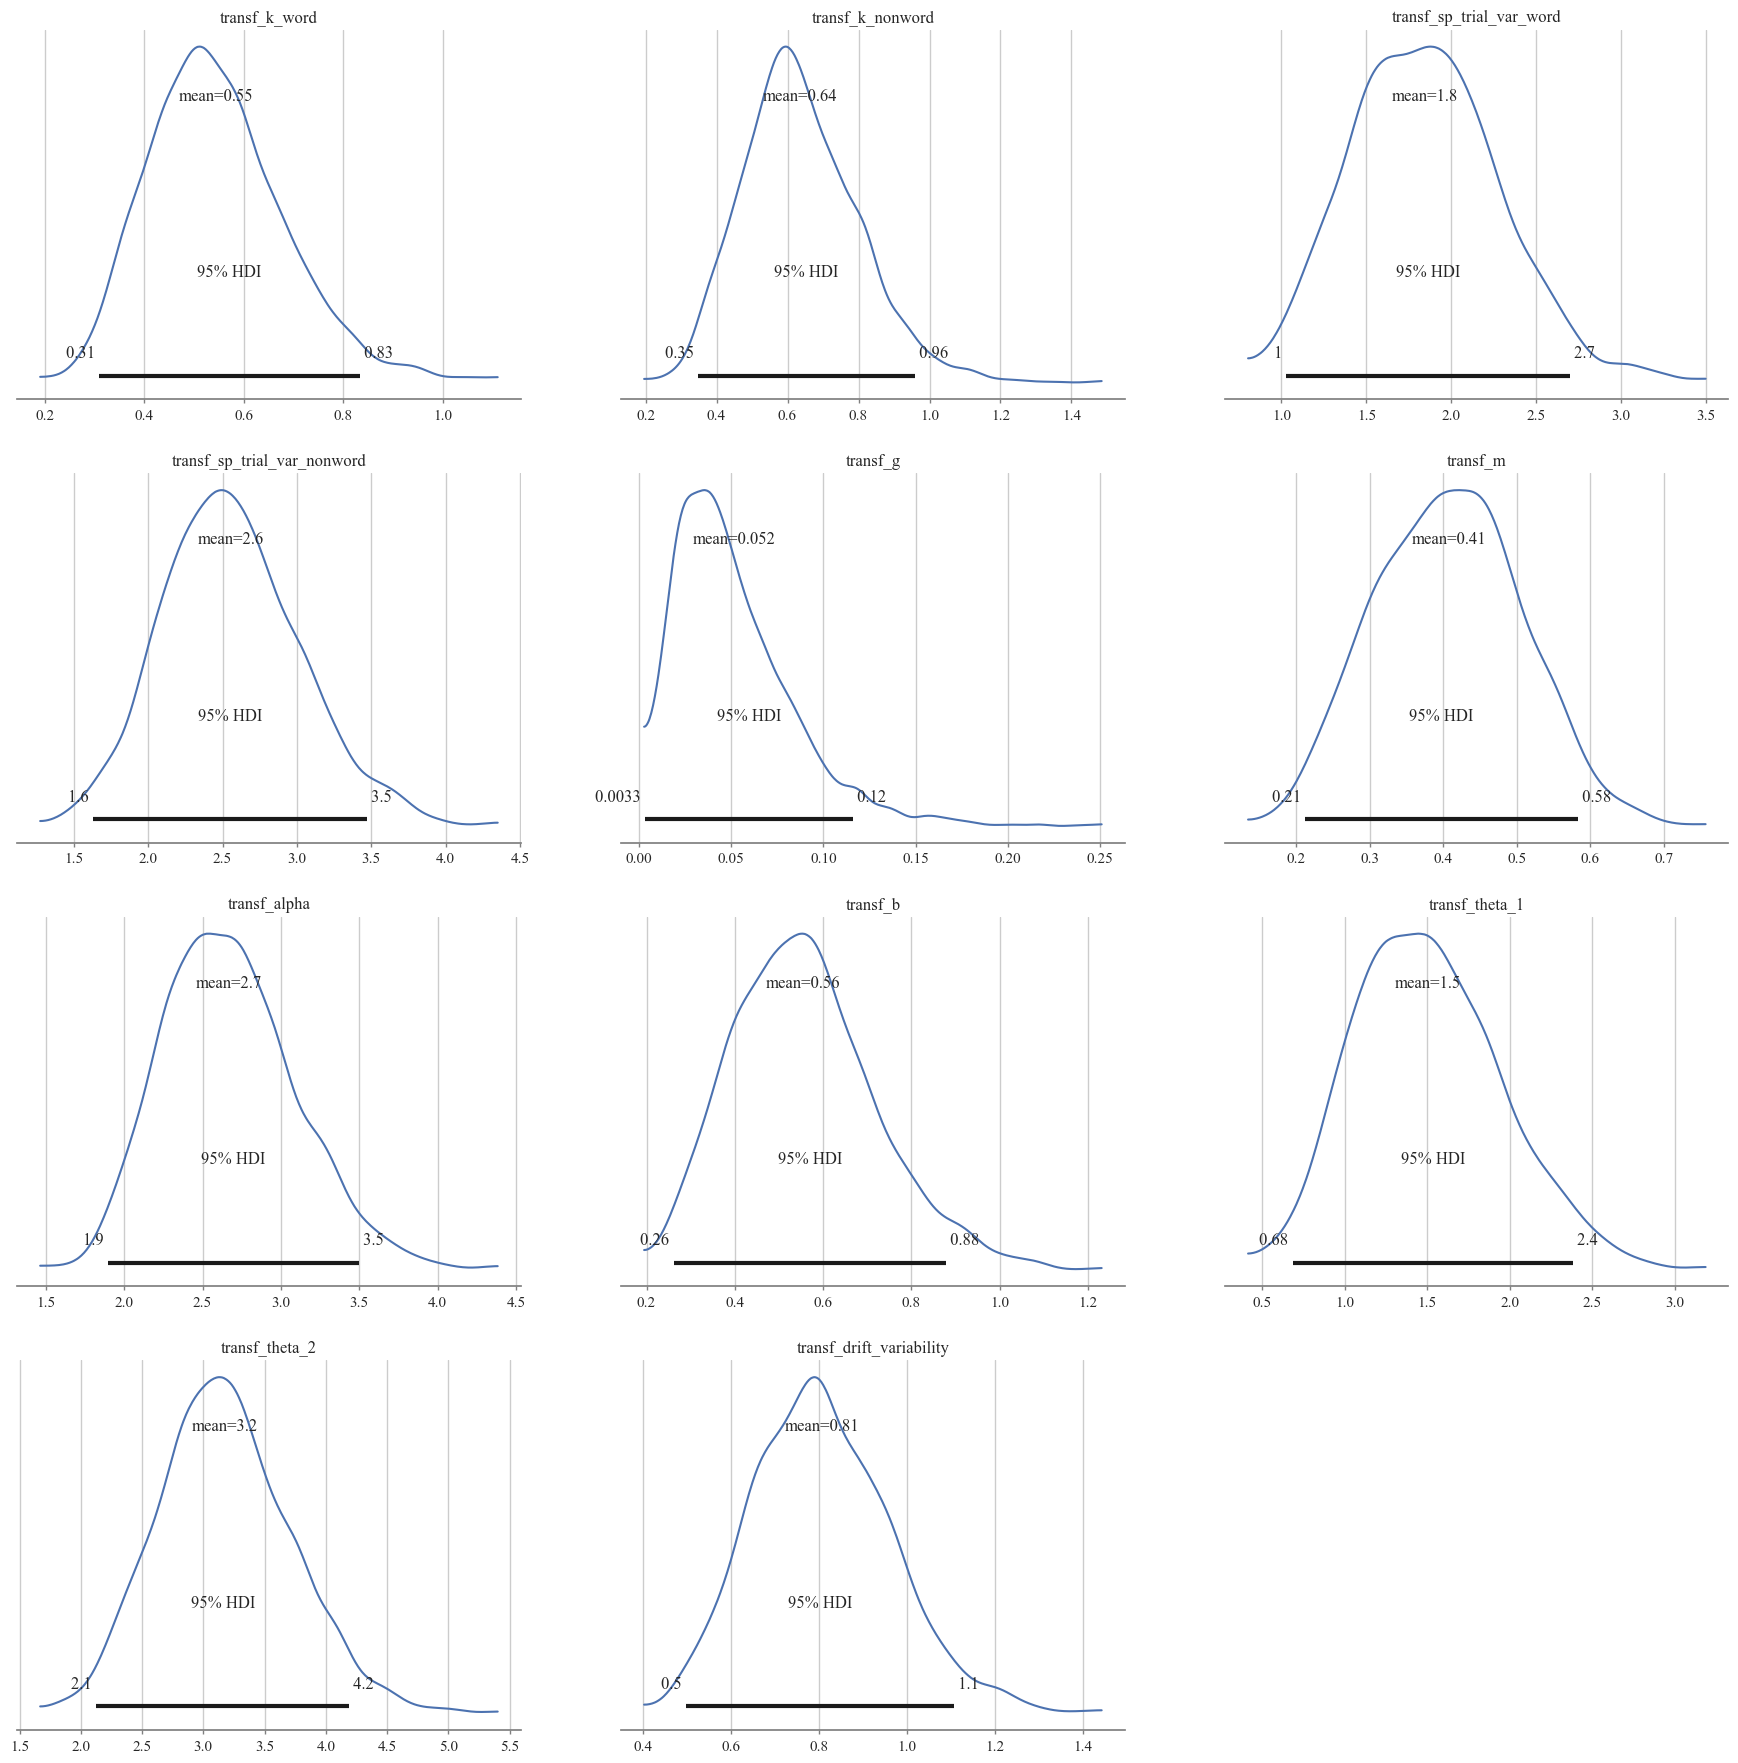

In [21]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [22]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
drift_variability_t = fit.stan_variables()['drift_variability_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    sp_t_word = fit.stan_variables()['sp_trial_var_t_word']
    sp_t_nonword = fit.stan_variables()['sp_trial_var_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    sp_trial_var_t = fit.stan_variables()['sp_trial_var_t']

#### Models mean parameters in different conditions

In [23]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [24]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
2.5846778931176466 0.5087411219994702
HF words, nonword drift mean and std:
0.6763787721117647 0.17021571796558077
LF words word drift mean and std:
1.946326920359756 0.3995663520301846
LF words nonword drift mean and std:
0.6860633645426828 0.17081045658332417
NW words word drift mean and std:
0.32114871275591134 0.1042058503185922
NW words nonword drift mean and std:
2.4922927075 0.42276280637304325


In [25]:
if model_config['model_name'] != "LBA":
    sp_HF_condition_w = sp_t_word[:, behavioural_df['category']=="HF"]
    sp_HF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="HF"]
    sp_LF_condition_w = sp_t_word[:, behavioural_df['category']=="LF"]
    sp_LF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="LF"]
    sp_NW_condition_w = sp_t_word[:, behavioural_df['category']=="NW"]
    sp_NW_condition_nw = sp_t_nonword[:, behavioural_df['category']=="NW"]
else:
    sp_HF_condition = sp_trial_var_t[:, behavioural_df['category']=="HF"]
    sp_LF_condition = sp_trial_var_t[:, behavioural_df['category']=="LF"]
    sp_NW_condition = sp_trial_var_t[:, behavioural_df['category']=="NW"]

In [26]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_w, axis=1)), np.std(np.mean(sp_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_nw, axis=1)), np.std(np.mean(sp_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_w, axis=1)), np.std(np.mean(sp_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_nw, axis=1)), np.std(np.mean(sp_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_w, axis=1)), np.std(np.mean(sp_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_nw, axis=1)), np.std(np.mean(sp_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition, axis=1)), np.std(np.mean(sp_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition, axis=1)), np.std(np.mean(sp_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition, axis=1)), np.std(np.mean(sp_NW_condition, axis=1)))

HF words, word starting point mean and std:
1.8481211935000001 0.4420425191351156
HF words, nonword starting point mean and std:
2.55593822 0.46379585148654734
LF words word starting point mean and std:
1.8481211935000001 0.4420425191351156
LF words nonword starting point mean and std:
2.55593822 0.46379585148654734
NW words word starting point mean and std:
1.8481211935 0.44204251913511566
NW words nonword starting point mean and std:
2.55593822 0.46379585148654756


In [27]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = sp_HF_condition_w + sp_HF_condition_w
    t_HF_condition_nw = sp_HF_condition_nw + sp_HF_condition_nw
    t_LF_condition_w = sp_LF_condition_w + sp_LF_condition_w
    t_LF_condition_nw = sp_LF_condition_nw + sp_LF_condition_nw
    t_NW_condition_w = sp_NW_condition_w + sp_NW_condition_w
    t_NW_condition_nw = sp_NW_condition_nw + sp_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = sp_HF_condition + k_HF_condition
    t_LF_condition = sp_LF_condition + k_LF_condition
    t_NW_condition = sp_NW_condition + k_NW_condition

In [28]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
3.6962423870000003 0.8840850382702312
HF words, nonword threshold mean and std:
5.11187644 0.9275917029730947
LF words word threshold mean and std:
3.6962423870000003 0.8840850382702312
LF words nonword threshold mean and std:
5.11187644 0.9275917029730947
NW words word threshold mean and std:
3.696242387 0.8840850382702313
NW words nonword threshold mean and std:
5.11187644 0.9275917029730951


In [29]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - sp_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - sp_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - sp_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - sp_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - sp_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - sp_NW_condition_nw

In [30]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))

HF words, word bias mean and std:
1.8481211935000001 0.4420425191351156
HF words, nonword bias mean and std:
2.55593822 0.46379585148654734
LF words word bias mean and std:
1.8481211935000001 0.4420425191351156
LF words nonword bias mean and std:
2.55593822 0.46379585148654734
NW words word bias mean and std:
1.8481211935 0.44204251913511566
NW words nonword bias mean and std:
2.55593822 0.46379585148654756


In [31]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [32]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.21397159778235295 0.02747432607580629
LF words ndt mean and std:
0.2160965837682927 0.02727534709317049
Non Words ndt mean and std:
0.2276716545 0.027341932813960523


## Calculating metrics

In [33]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -240.30669884254593, 'p_waic': 9.204411135857262, 'waic': 499.0222199568064, 'waic_se': 43.47145989500499}


## Simulating LBA with estimated parameters

Simulating LBA with estimated parameters

In [34]:
if model_config["model_name"] != "RDM":
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_t_word, sp_t_nonword,
                                       ndt_t, k_t_word, k_t_nonword, drift_variability_t)
else:
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_trial_var_t, sp_trial_var_t,
                                       ndt_t, k_t, k_t, drift_variability_t)

In [35]:
# Predicted Data
tmp1 = pd.DataFrame(pp_rt,
                    index=pd.Index(np.arange(1, len(pp_rt)+1), name="sample"),
                    columns=pd.MultiIndex.from_product((["rt"],
                                                        np.arange(pp_rt.shape[1])),
                                                        names=["variable", "trial"]))
tmp2 = pd.DataFrame(pp_response,
                    index=pd.Index(np.arange(1, len(pp_response)+1), name="sample"),
                    columns=pd.MultiIndex.from_product((["response"],
                                                        np.arange(pp_response.shape[1])),
                                                               names=["variable", "trial"]))
predictedData = pd.concat((tmp1, tmp2), axis=1)

## RT Quantiles Posterior Predictions Checks

In [36]:
quantiles = [.1, .3, .5, .7, .9]

### All Trials

In [37]:
exp_all_trials, pred_all_trials = get_dfs(behavioural_df, predictedData)

In [38]:
all_quantiles_ex = exp_all_trials["rt"].quantile(quantiles)
all_quantiles_pred = pred_all_trials.quantile(quantiles, axis=1).T
all_predicted_bci = np.array([bci(all_quantiles_pred[x]) for x in quantiles])

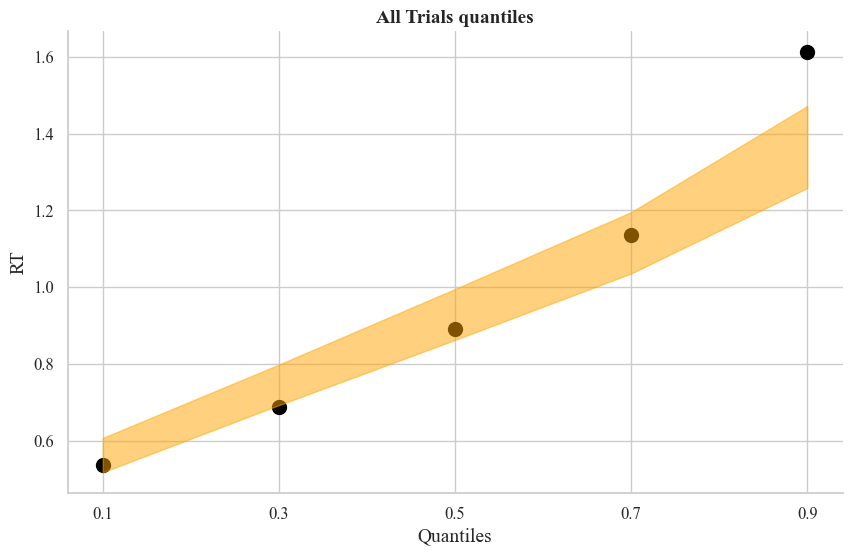

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

ax.set_title("All Trials quantiles", fontweight="bold", size=14)
ax.scatter(quantiles, all_quantiles_ex, color="black", s=100)

ax.fill_between(quantiles,
                all_predicted_bci[:, 0],
                all_predicted_bci[:, 1],
                all_predicted_bci[:, 0] < all_predicted_bci[:, 1],  color = "orange", alpha=0.5)

ax.set_xlabel("Quantiles", fontsize=14)
ax.set_xticks(quantiles)
ax.set_xticklabels(quantiles)
ax.set_ylabel("RT", fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials.pdf")

### All Trials (word response vs non-word response)

In [40]:
exp_word_resp_all, pred_word_resp_all = get_dfs(behavioural_df, predictedData,
                                                response=1)
exp_nonword_resp_all, pred_nonword_resp_all = get_dfs(behavioural_df, predictedData,
                                                      response=0)

In [41]:
word_quantiles_ex = exp_word_resp_all["rt"].quantile(quantiles)
nonword_quantiles_ex = exp_nonword_resp_all["rt"].quantile(quantiles)

word_quantiles_pred = pred_word_resp_all.quantile(quantiles, axis=1).T
nonword_quantiles_pred = pred_nonword_resp_all.quantile(quantiles, axis=1).T

word_predicted_bci = np.array([bci(word_quantiles_pred[x]) for x in quantiles])
nonword_predicted_bci = np.array([bci(nonword_quantiles_pred[x]) for x in quantiles])

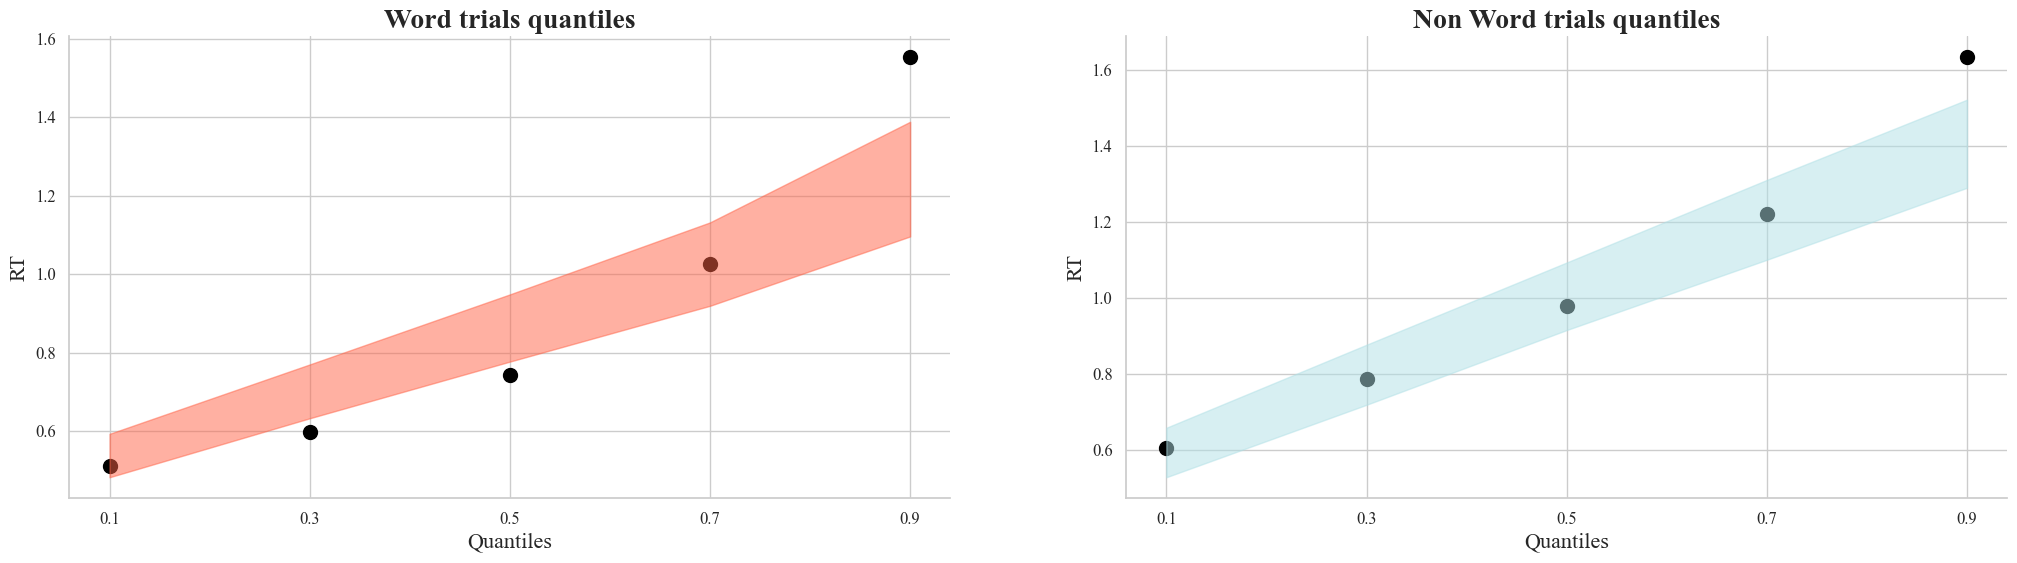

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title("Word trials quantiles", fontweight="bold", size=20)
axes[1].set_title("Non Word trials quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, word_quantiles_ex, color="black", s=100)
axes[1].scatter(quantiles, nonword_quantiles_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                word_predicted_bci[:, 0],
                word_predicted_bci[:, 1],
                word_predicted_bci[:, 0] < word_predicted_bci[:, 1],  color = "tomato", alpha=0.5)

axes[1].fill_between(quantiles,
                nonword_predicted_bci[:, 0],
                nonword_predicted_bci[:, 1],
                nonword_predicted_bci[:, 0] < nonword_predicted_bci[:, 1],  color = "powderblue", alpha=0.5)

for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=16)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RT", fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials-Word vs Nonword.pdf")

### All trials (Correct Choice vs Incorrect Choice) 

In [43]:
exp_cor_choice_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=1)
exp_incor_resp_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=0)
pred_cor_choice_all = predictedData["rt"][predictedData["response"]==behavioural_df["label"]]
pred_incor_choice_all = predictedData["rt"][predictedData["response"]!=behavioural_df["label"]]

In [44]:
cor_quantiles_ex = exp_cor_choice_all["rt"].quantile(quantiles)
incor_quantiles_ex = exp_incor_resp_all["rt"].quantile(quantiles)

cor_quantiles_pred = pred_cor_choice_all.quantile(quantiles, axis=1).T
incor_quantiles_pred = pred_incor_choice_all.quantile(quantiles, axis=1).T

cor_predicted_bci = np.array([bci(cor_quantiles_pred[x]) for x in quantiles])
incor_predicted_bci = np.array([bci(incor_quantiles_pred[x]) for x in quantiles])

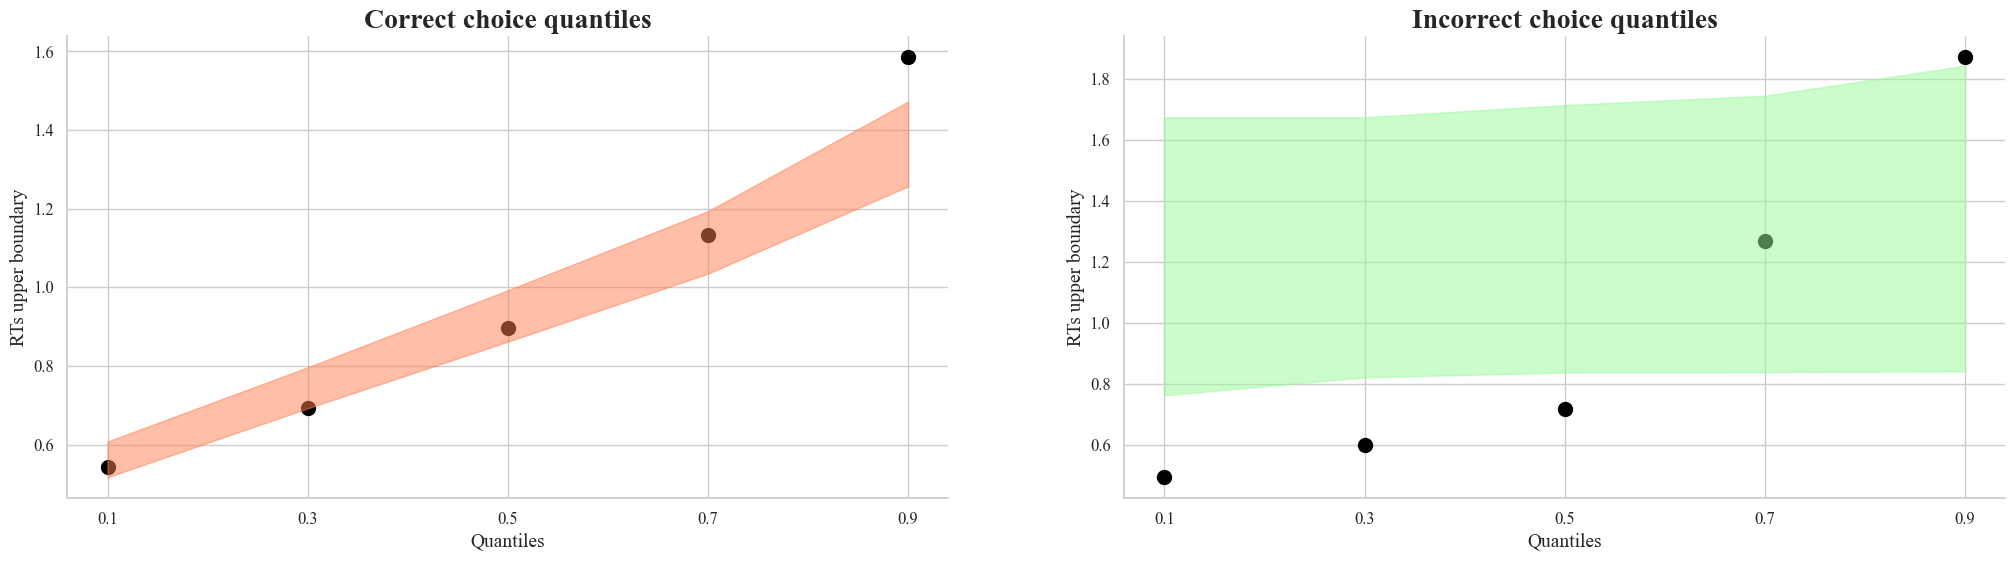

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title("Correct choice quantiles", fontweight="bold", size=20)
axes[1].set_title("Incorrect choice quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, cor_quantiles_ex, color="black", s=100)
axes[1].scatter(quantiles, incor_quantiles_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                cor_predicted_bci[:, 0],
                cor_predicted_bci[:, 1],
                cor_predicted_bci[:, 0] < cor_predicted_bci[:, 1],  color = "coral", alpha=0.5)

axes[1].fill_between(quantiles,
                incor_predicted_bci[:, 0],
                incor_predicted_bci[:, 1],
                incor_predicted_bci[:, 0] < incor_predicted_bci[:, 1],  color = "palegreen", alpha=0.5)

for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=14)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials-Correct vs Incorrect.pdf")

### Conditional (HF, LF, NW trials)

In [46]:
exp_HF_trials, pred_HF_trials = get_dfs(behavioural_df, predictedData,
                                        category="HF")
exp_LF_trials, pred_LF_trials = get_dfs(behavioural_df, predictedData,
                                        category="LF")
exp_NW_trials, pred_NW_trials = get_dfs(behavioural_df, predictedData,
                                        category="NW")

In [47]:
# experiment Data quantile
HF_quantile_ex = exp_HF_trials["rt"].quantile(quantiles)
LF_quantile_ex = exp_LF_trials["rt"].quantile(quantiles)
NW_quantile_ex = exp_NW_trials["rt"].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

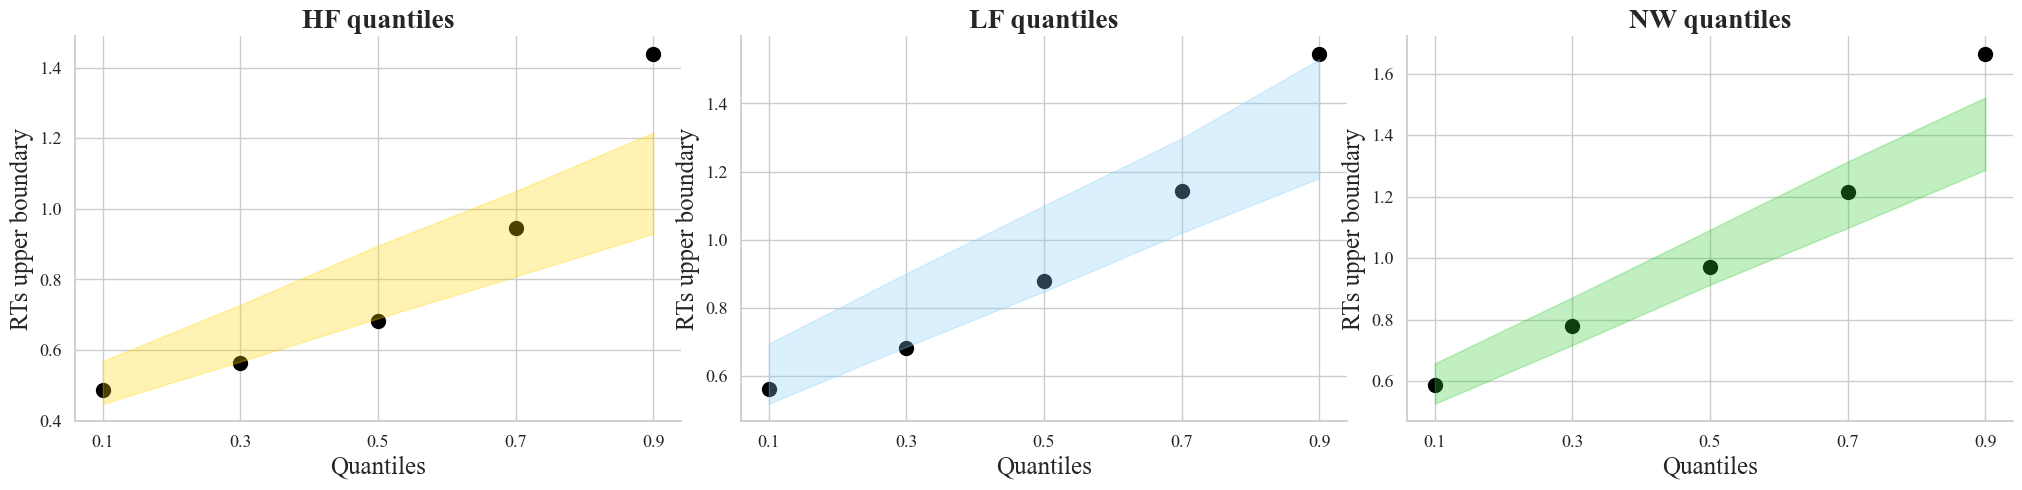

In [48]:
fig, axes = plt.subplots(1,3 , figsize=(25,5))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axes[0].set_title("HF quantiles", fontweight="bold", size=20)
axes[1].set_title("LF quantiles", fontweight="bold", size=20)
axes[2].set_title("NW quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color="black", s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color="black", s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-Conditional.pdf")

### Conditional (HF, LF, NW trials) for word response and nonword response

In [49]:
exp_word_resp_HF, pred_word_resp_HF = get_dfs(behavioural_df, predictedData,
                                              category="HF", response=1)
exp_word_resp_LF, pred_word_resp_LF = get_dfs(behavioural_df, predictedData,
                                              category="LF", response=1)
exp_word_resp_NW, pred_word_resp_NW = get_dfs(behavioural_df, predictedData,
                                              category="NW", response=1)

exp_nonword_resp_HF, pred_nonword_resp_HF = get_dfs(behavioural_df, predictedData,
                                                    category="HF", response=0)
exp_nonword_resp_LF, pred_nonword_resp_LF = get_dfs(behavioural_df, predictedData,
                                                    category="LF", response=0)
exp_nonword_resp_NW, pred_nonword_resp_NW = get_dfs(behavioural_df, predictedData,
                                                    category="NW", response=0)

In [50]:
# experiment Data quantile
HF_word_quantile_ex = exp_word_resp_HF["rt"].quantile(quantiles)
LF_word_quantile_ex = exp_word_resp_LF["rt"].quantile(quantiles)
NW_word_quantile_ex = exp_word_resp_NW["rt"].quantile(quantiles)

HF_nonword_quantile_ex = exp_nonword_resp_HF["rt"].quantile(quantiles)
LF_nonword_quantile_ex = exp_nonword_resp_LF["rt"].quantile(quantiles)
NW_nonword_quantile_ex = exp_nonword_resp_NW["rt"].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_word_quantile_pred = pred_word_resp_HF.quantile(quantiles, axis=1).T
LF_word_quantile_pred = pred_word_resp_LF.quantile(quantiles, axis=1).T
NW_word_quantile_pred = pred_word_resp_NW.quantile(quantiles, axis=1).T

HF_nonword_quantile_pred = pred_nonword_resp_HF.quantile(quantiles, axis=1).T
LF_nonword_quantile_pred = pred_nonword_resp_LF.quantile(quantiles, axis=1).T
NW_nonword_quantile_pred = pred_nonword_resp_NW.quantile(quantiles, axis=1).T


# predicted data quantiles bci
HF_word_predicted_bci = np.array([bci(HF_word_quantile_pred[x]) for x in quantiles])
LF_word_predicted_bci = np.array([bci(LF_word_quantile_pred[x]) for x in quantiles])
NW_word_predicted_bci = np.array([bci(NW_word_quantile_pred[x]) for x in quantiles])

HF_nonword_predicted_bci = np.array([bci(HF_nonword_quantile_pred[x]) for x in quantiles])
LF_nonword_predicted_bci = np.array([bci(LF_nonword_quantile_pred[x]) for x in quantiles])
NW_nonword_predicted_bci = np.array([bci(NW_nonword_quantile_pred[x]) for x in quantiles])

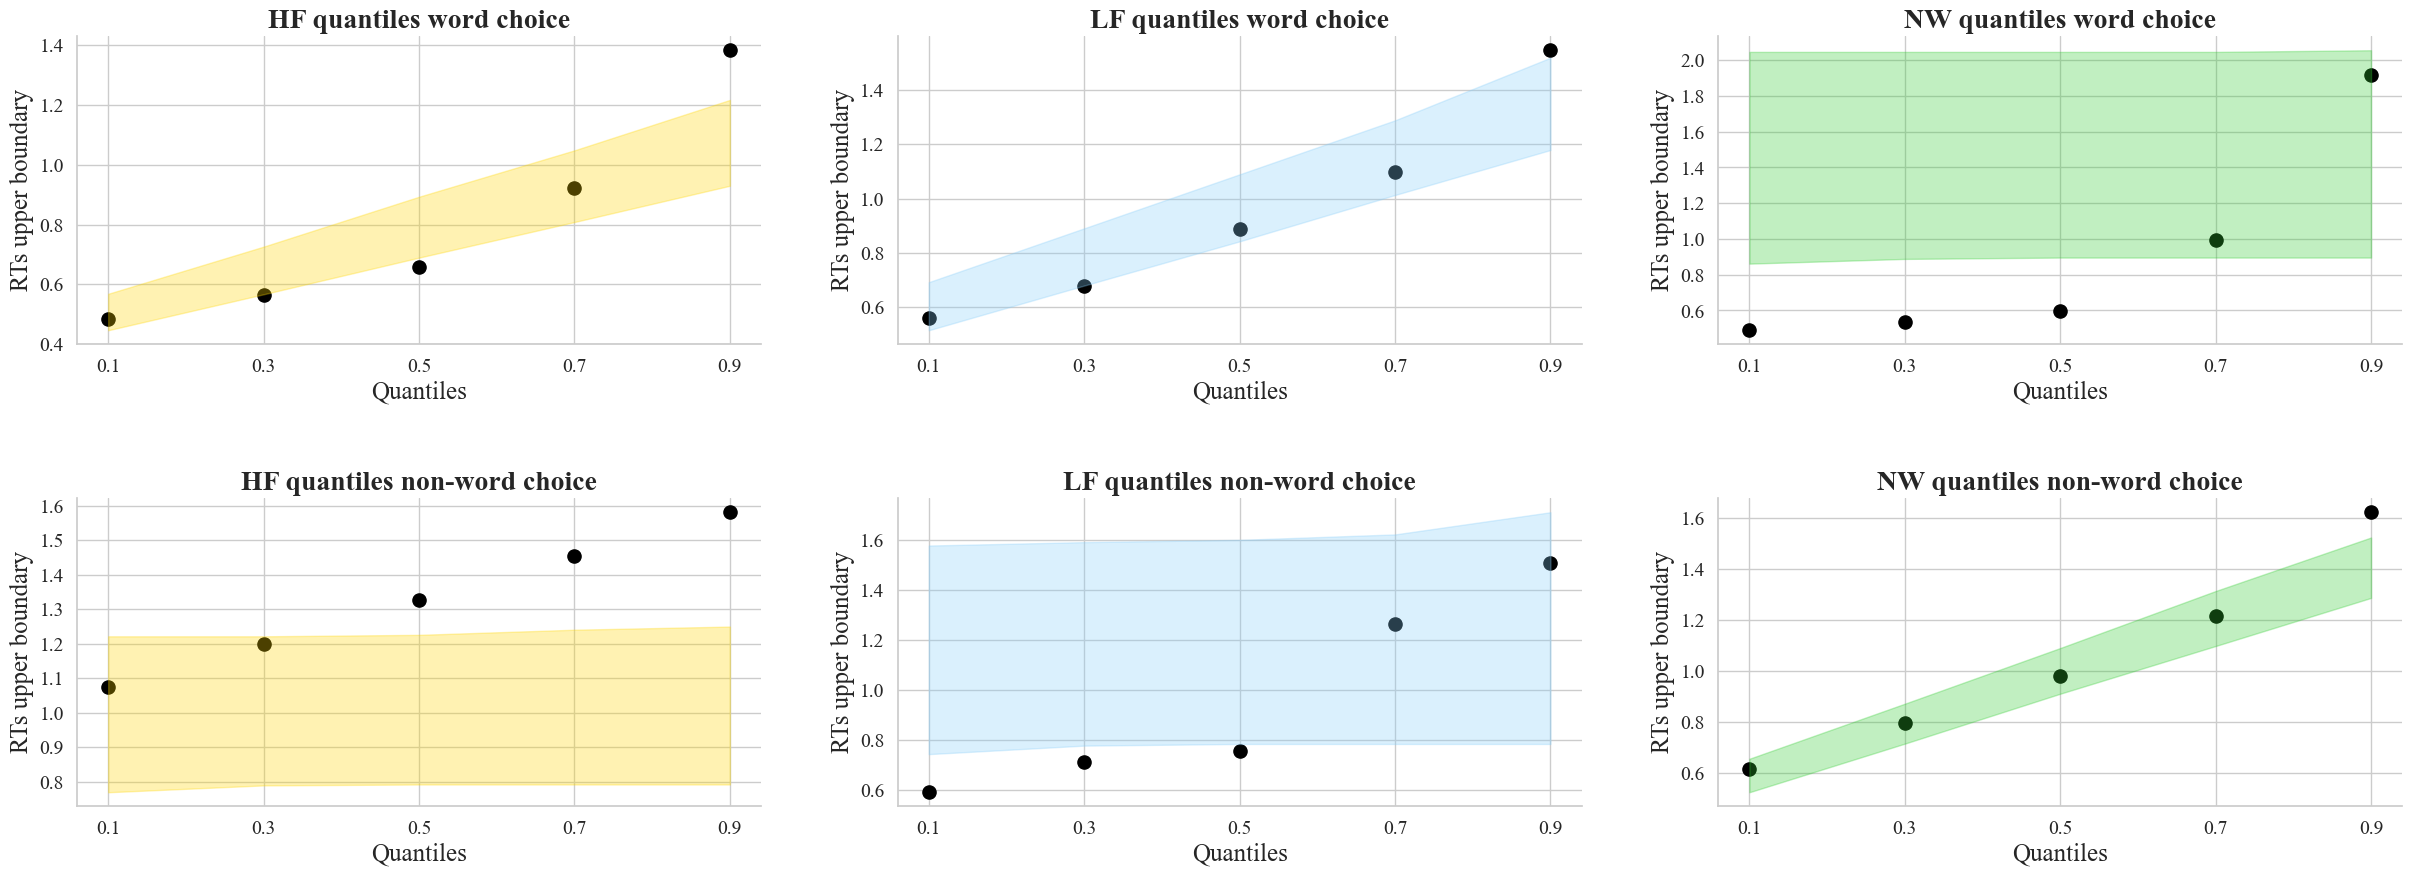

In [51]:
fig, axes = plt.subplots(2,3 , figsize=(30,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0][0].set_title("HF quantiles word choice", fontweight="bold", size=20)
axes[0][1].set_title("LF quantiles word choice", fontweight="bold", size=20)
axes[0][2].set_title("NW quantiles word choice", fontweight="bold", size=20)

axes[1][0].set_title("HF quantiles non-word choice", fontweight="bold", size=20)
axes[1][1].set_title("LF quantiles non-word choice", fontweight="bold", size=20)
axes[1][2].set_title("NW quantiles non-word choice", fontweight="bold", size=20)

axes[0][0].scatter(quantiles, HF_word_quantile_ex, color="black", s=90)
axes[0][1].scatter(quantiles, LF_word_quantile_ex, color="black", s=90)
axes[0][2].scatter(quantiles, NW_word_quantile_ex, color="black", s=90)

axes[1][0].scatter(quantiles, HF_nonword_quantile_ex, color="black", s=90)
axes[1][1].scatter(quantiles, LF_nonword_quantile_ex, color="black", s=90)
axes[1][2].scatter(quantiles, NW_nonword_quantile_ex, color="black", s=90)


axes[0][0].fill_between(quantiles,
                HF_word_predicted_bci[:, 0],
                HF_word_predicted_bci[:, 1],
                HF_word_predicted_bci[:, 0] < HF_word_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[0][1].fill_between(quantiles,
                LF_word_predicted_bci[:, 0],
                LF_word_predicted_bci[:, 1],
                LF_word_predicted_bci[:, 0] < LF_word_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[0][2].fill_between(quantiles,
                NW_word_predicted_bci[:, 0],
                NW_word_predicted_bci[:, 1],
                NW_word_predicted_bci[:, 0] < NW_word_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


axes[1][0].fill_between(quantiles,
                HF_nonword_predicted_bci[:, 0],
                HF_nonword_predicted_bci[:, 1],
                HF_nonword_predicted_bci[:, 0] < HF_nonword_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[1][1].fill_between(quantiles,
                LF_nonword_predicted_bci[:, 0],
                LF_nonword_predicted_bci[:, 1],
                LF_nonword_predicted_bci[:, 0] < LF_nonword_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[1][2].fill_between(quantiles,
                NW_nonword_predicted_bci[:, 0],
                NW_nonword_predicted_bci[:, 1],
                NW_nonword_predicted_bci[:, 0] < NW_nonword_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


for ax_d1 in axes:
    for ax in ax_d1:
        ax.set_xlabel("Quantiles", fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-Conditional-Word vs Nonword.pdf")

## Mean Accuracy and RT Posterior Prediction Checks


### All trials

In [52]:
exp_all_trials_rt, pred_all_trials_rt = get_dfs(behavioural_df, predictedData)
exp_all_trials_resp, pred_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                    pred_df_type="response")

In [53]:
all_data_rt_mean = exp_all_trials_rt["rt"].mean()
all_pred_rt_mean = pred_all_trials_rt.mean(axis=1)

all_data_resp_mean = exp_all_trials_resp["response"].mean()
all_pred_resp_mean = pred_all_trials_resp.mean(axis=1)

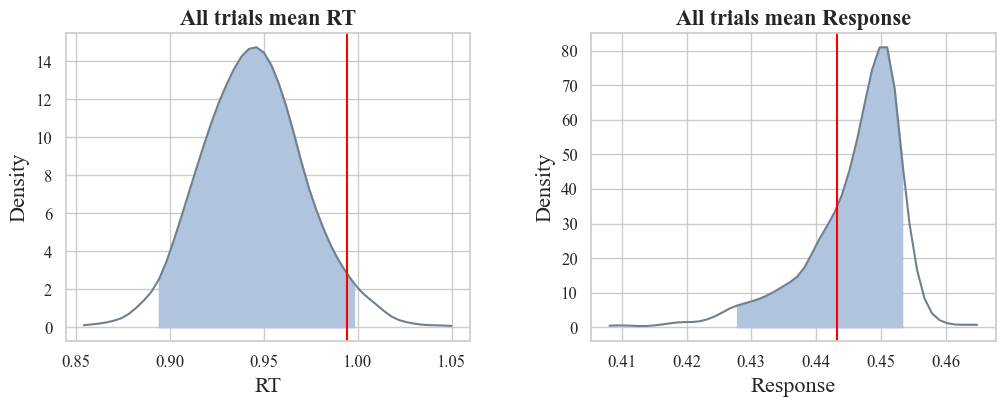

In [54]:
fig, axes = plt.subplots(1,2 , figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0].set_title("All trials mean RT", fontweight="bold", size=16)
axes[1].set_title("All trials mean Response", fontweight="bold", size=16)

plot_mean_posterior(all_pred_rt_mean, all_data_rt_mean, axes[0])
plot_mean_posterior(all_pred_resp_mean, all_data_resp_mean, axes[1])

axes[0].set_xlabel("RT", fontsize=16)
axes[1].set_xlabel("Response", fontsize=16)

for ax in axes:
        ax.set_ylabel("Density", fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
            
plt.savefig(plots_path + "PPC-Mean Accuracy and RT-All trials.pdf")

### All Trials (correct choice vs incorrect choice)

In [55]:
exp_cor_all_trials_rt, pred_cor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                        accuracy=1)
exp_incor_all_trials_rt, pred_incor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                            accuracy=0)

exp_cor_all_trials_resp, pred_cor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                            accuracy=1, pred_df_type="response")
exp_incor_all_trials_resp, pred_incor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                                accuracy=0, pred_df_type="response")

In [56]:
all_trials_cor_rt_mean = exp_cor_all_trials_rt["rt"].mean()
all_pred_cor_rt_mean = pred_cor_all_trials_rt.mean(axis=1)

all_trials_incor_rt_mean = exp_incor_all_trials_rt["rt"].mean()
all_pred_incor_rt_mean = pred_incor_all_trials_rt.mean(axis=1)


all_data_cor_resp_mean = exp_cor_all_trials_resp["response"].mean()
all_pred_cor_resp_mean = pred_cor_all_trials_resp.mean(axis=1)

all_data_incor_resp_mean = exp_incor_all_trials_resp["response"].mean()
all_pred_incor_resp_mean = pred_incor_all_trials_resp.mean(axis=1)

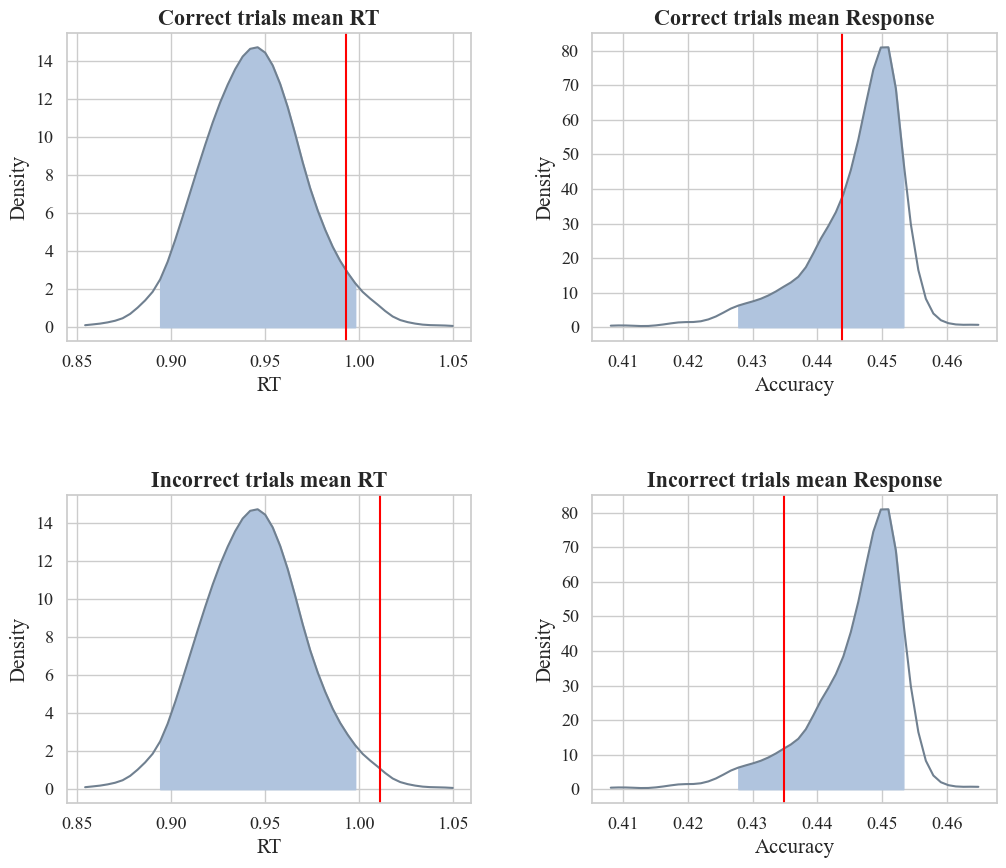

In [57]:
fig, axes = plt.subplots(2,2 , figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title("Correct trials mean RT", fontweight="bold", size=16)
axes[0][1].set_title("Correct trials mean Response", fontweight="bold", size=16)
axes[1][0].set_title("Incorrect trials mean RT", fontweight="bold", size=16)
axes[1][1].set_title("Incorrect trials mean Response", fontweight="bold", size=16)

plot_mean_posterior(all_pred_cor_rt_mean, all_trials_cor_rt_mean, axes[0][0])
plot_mean_posterior(all_pred_cor_resp_mean, all_data_cor_resp_mean, axes[0][1])

plot_mean_posterior(all_pred_incor_rt_mean, all_trials_incor_rt_mean, axes[1][0])
plot_mean_posterior(all_pred_incor_resp_mean, all_data_incor_resp_mean, axes[1][1])

for ax in axes:
        ax[0].set_xlabel("RT", fontsize=15)
        ax[1].set_xlabel("Accuracy", fontsize=15)
        ax[0].set_ylabel("Density", fontsize=15)
        ax[1].set_ylabel("Density", fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + "PPC-Mean Accuracy and RT-All trials-Correct vs Incorrect.pdf")

### Conditional (HF, LF, NW trials) 

In [58]:
exp_HF_trials_rt, pred_HF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="HF")
exp_LF_trials_rt, pred_LF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="LF")
exp_NW_trials_rt, pred_NW_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="NW")

exp_HF_trials_resp, pred_HF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="HF", pred_df_type="response")
exp_LF_trials_resp, pred_LF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="LF", pred_df_type="response")
exp_NW_trials_resp, pred_NW_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="NW", pred_df_type="response")

In [59]:
HF_data_rt_mean = exp_HF_trials_rt["rt"].mean()
LF_data_rt_mean = exp_LF_trials_rt["rt"].mean()
NW_data_rt_mean = exp_NW_trials_rt["rt"].mean()

HF_pred_rt_mean = pred_HF_trials_rt.mean(axis=1)
LF_pred_rt_mean = pred_LF_trials_rt.mean(axis=1)
NW_pred_rt_mean = pred_NW_trials_rt.mean(axis=1)


HF_data_resp_mean = exp_HF_trials_resp["response"].mean()
LF_data_resp_mean = exp_LF_trials_resp["response"].mean()
NW_data_resp_mean = exp_NW_trials_resp["response"].mean()

HF_pred_resp_mean = pred_HF_trials_resp.mean(axis=1)
LF_pred_resp_mean = pred_LF_trials_resp.mean(axis=1)
NW_pred_resp_mean = pred_NW_trials_resp.mean(axis=1)


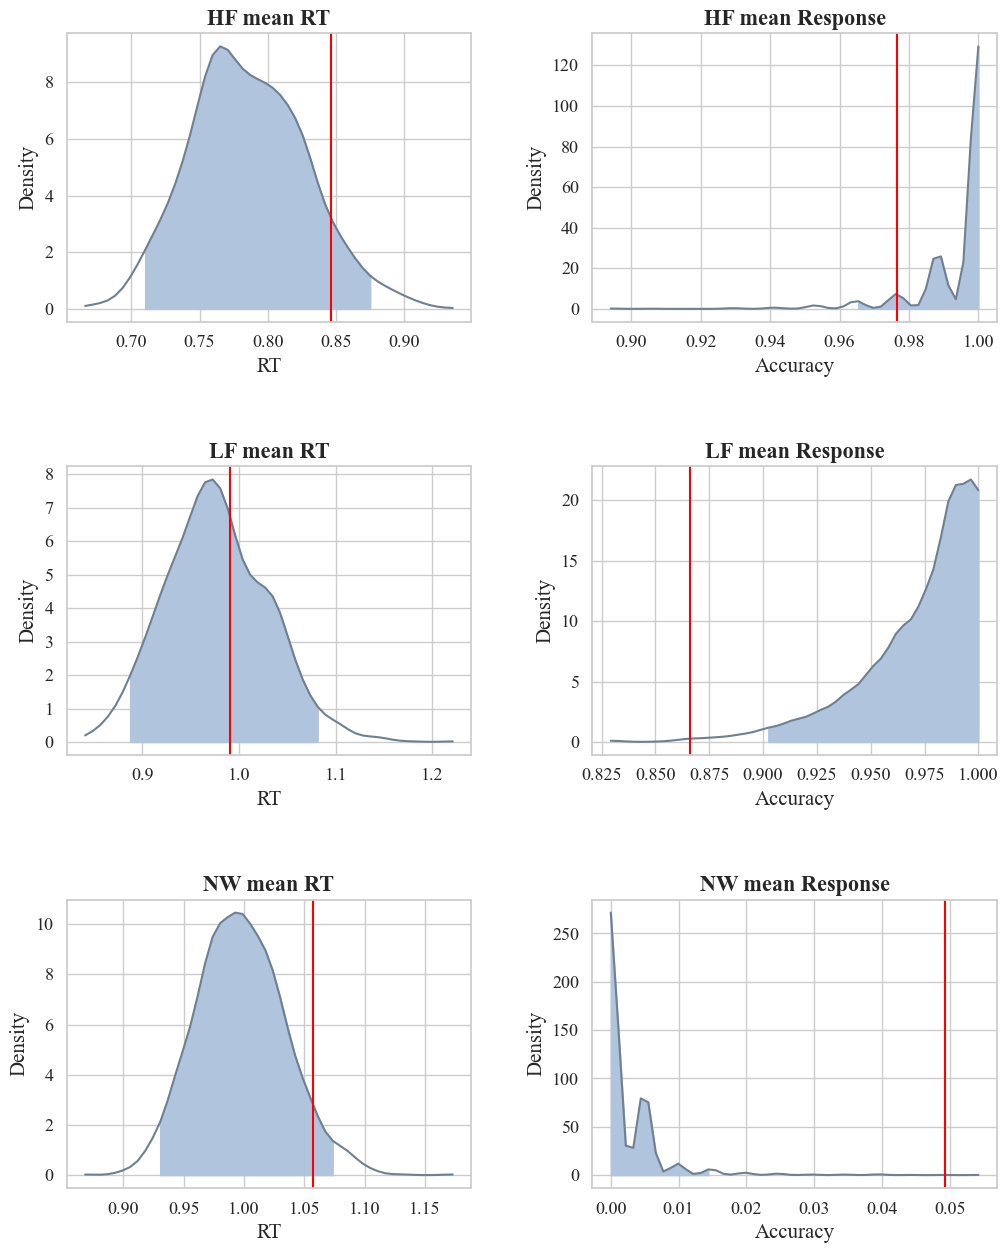

In [60]:
fig, axes = plt.subplots(3,2 , figsize=(12,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title("HF mean RT", fontweight="bold", size=16)
axes[0][1].set_title("HF mean Response", fontweight="bold", size=16)
axes[1][0].set_title("LF mean RT", fontweight="bold", size=16)
axes[1][1].set_title("LF mean Response", fontweight="bold", size=16)
axes[2][0].set_title("NW mean RT", fontweight="bold", size=16)
axes[2][1].set_title("NW mean Response", fontweight="bold", size=16)

plot_mean_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_mean_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_mean_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_mean_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_mean_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_mean_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel("RT", fontsize=15)
        ax[1].set_xlabel("Accuracy", fontsize=15)
        ax[0].set_ylabel("Density", fontsize=15)
        ax[1].set_ylabel("Density", fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + "PPC-Mean Accuracy and RT-Conditional.pdf")